# Structure
This notebook has the following structure/sequence:
1. Data Exploration
2. Data Preparation
3. Single Optimizer Code
4. Hybrid Learning Code
5. Heatmaps
6. Statistical Tests & Other Visualisations

In [345]:
"""
NB: The flags in this cell determine which parts of the code are run.
    Setting them to False will load precomputed results.
"""

# Set to True to perform a random data split again
PERFORM_NEW_DATA_SPLIT = False

# Set to True to perform the grid search again (Warning: this will take an extremely long time, several hours when using the GPU)
RUN_GRID_SEARCH = False

# Set to True to perform the test set evaluation again (Warning: this could take a long time)
PERFORM_TEST_SET_EVALUATION = False

# Set to True to perform the hybrid evaluation again (Warning: this will take a very long time > 30 minutes when using the GPU)
PERFORM_HYBRID_EVALUATION = False

In [346]:
# Necessary imports
import os
import json
import copy

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from torch import nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


# Data Exploration
Only basic data exploration was performed, the goal mainly being to see the distribution of data and the number of missing values for each feature

In [347]:
# paths
data_dir = r'data'
data_pth = os.path.join(data_dir, r'Almond.csv')

data = pd.read_csv(data_pth)

# Drop the first (index) column
data = data.drop(data.columns[0], axis=1)

print("Number of rows: ", data.shape[0])
print("Number of cols: ", data.shape[1])
print("Columns: ", [col for col in data.columns])
print("==========================================")

print("Num unique types: ", data['Type'].nunique())
print("Unique types:\n", data['Type'].value_counts())

# print number of null values per column
print("==========================================")
print("Number of null values per column:")
print(data.isnull().sum())


Number of rows:  2803
Number of cols:  13
Columns:  ['Length (major axis)', 'Width (minor axis)', 'Thickness (depth)', 'Area', 'Perimeter', 'Roundness', 'Solidity', 'Compactness', 'Aspect Ratio', 'Eccentricity', 'Extent', 'Convex hull(convex area)', 'Type']
Num unique types:  3
Unique types:
 Type
SANORA     943
MAMRA      933
REGULAR    927
Name: count, dtype: int64
Number of null values per column:
Length (major axis)          857
Width (minor axis)           942
Thickness (depth)           1004
Area                           0
Perimeter                      0
Roundness                    857
Solidity                       0
Compactness                    0
Aspect Ratio                1799
Eccentricity                1799
Extent                         0
Convex hull(convex area)       0
Type                           0
dtype: int64


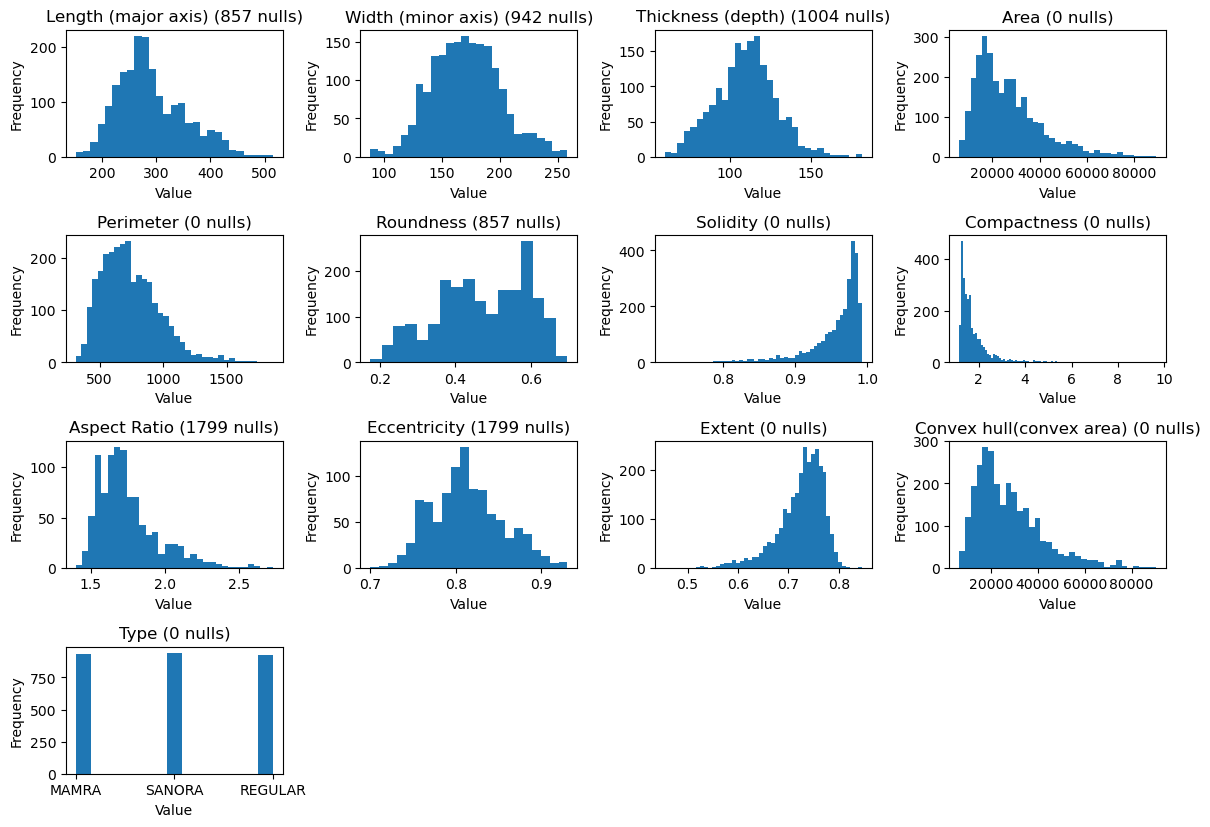

In [348]:
"""
Plot a subplot histogram for each column, ignore null values
"""

fig, axs = plt.subplots(5, 4, figsize=(12, 10))

flat_axs = axs.flatten()
for i, col in enumerate(data.columns):
    non_null_data = data[col].dropna()
    num_null = data[col].isnull().sum()
    flat_axs[i].hist(non_null_data, bins='auto')
    flat_axs[i].set_title(col + f' ({num_null} nulls)')
    flat_axs[i].set_xlabel('Value')
    flat_axs[i].set_ylabel('Frequency')
    

# hide the unused subplots
for i in range(data.shape[1], len(flat_axs)):
    fig.delaxes(flat_axs[i])

plt.tight_layout()
plt.show()


# Data Preparation

In [349]:
"""
Functions and classes related to data preprocessing
"""

def data_split_basic(data, train_p=0.8):
    """ Splits data into training and testing sets. """
    # Shuffle the data
    data = data.sample(frac=1).reset_index(drop=True)
    
    # Split the data
    train = data.iloc[:int(train_p * len(data)), :]
    test = data.iloc[int(train_p * len(data)):, :]
    
    return train, test

def calculate_data_scale(train):
    """ Calculates scaling metrics for training data. """
    # Calculate scaling parameters
    scaling_params = train.describe().loc[['mean', 'std', 'min', 'max'], :]    
    return scaling_params

def save_scaling_params(scaling_params, pth):
    scaling_params.to_json(pth, indent=4)

def save_datasets(train, test, dir):
    """ Saves training and testing datasets to a directory. File names are 'train.csv' and 'test.csv'. """
    if not os.path.exists(os.path.join(data_dir, dir)):
        os.makedirs(os.path.join(data_dir, dir), exist_ok=True) # Create the directory if it doesn't exist
    train_pth = None
    if train is not None:
        train_pth = os.path.join(data_dir, dir, 'train.csv')
        train.to_csv(train_pth, index=False)
    
    test_pth = None
    if test is not None:
        test_pth = os.path.join(data_dir, dir, 'test.csv')
        test.to_csv(test_pth, index=False)
    
    return train_pth, test_pth

def mean_imputation(data):
    """Imputes missing values with the mean of numeric columns only."""
    numeric_columns = data.select_dtypes(include='number')
    return data.fillna(numeric_columns.mean())


In [350]:
if PERFORM_NEW_DATA_SPLIT:
    # Reread the data
    data = pd.read_csv(data_pth)

    # Drop the first (index) column
    data = data.drop(data.columns[0], axis=1)

    # Drop the Eccentricity and Aspect Ratio columns as they have have more than 50% missing values
    data = data.drop(['Eccentricity', 'Aspect Ratio'], axis=1)

    # Perform mean imputation
    data = mean_imputation(data)
    # See if any columns contain null values
    print("Contains null values: ", data.isnull().values.any())

    # Perform a basic split
    train, test = data_split_basic(data, train_p=0.9) # 90% training, 10% testing
    print(f"Training data shape: {train.shape}")
    print(f"Testing data shape: {test.shape}")
    scaling_params = calculate_data_scale(train) # Calculate scaling parameters on the training data
    train_pth, test_pth = save_datasets(train, test, "basic")
    save_scaling_params(scaling_params, os.path.join(data_dir, 'basic', 'scaling_params.json'))

# Code Related To Model Training With a Single Optimizer
## Structure:
1. Classes and functions related to the dataset and neural network
2. Hyperparameter Tuning
3. Runs on Test Set

In [351]:
"""
Classes and functions related to the dataset and data loading
"""

class AlmondDataset(Dataset):
    def __init__(self, data_dir, is_train=True, transform=None):
        target_file = 'train.csv' if is_train else 'test.csv'
        path = os.path.join(data_dir, target_file)

        # Convert the label to a numerical value
        self.label_map = {
            'MAMRA': 0,
            'REGULAR': 1,
            'SANORA': 2,
        }
        self.data = pd.read_csv(path)

        if not all(self.data["Type"].isin(self.label_map.keys())):
            raise ValueError("Invalid label in the dataset")

        self.labels = self.data['Type'].map(self.label_map).values
        self.labels = torch.tensor(self.labels, dtype=torch.long) # convert to tensor
        self.data = self.data.drop(columns=['Type'])

        self.transform = transform
        # eagerly transform the data
        if self.transform:
            self.data = self.transform(self.data)

        # convert data to tensor
        self.data = torch.tensor(self.data.values, dtype=torch.float)


    def num_classes(self):
        return len(self.label_map)
    
    def num_features(self):
        return self.data.shape[1]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


def read_scaling_params(filepath):
    with open(filepath, 'r') as f:
        return json.load(f)


def scale_to_range(val, unscaled_min, unscaled_max, scaled_min, scaled_max):
    return (val - unscaled_min) / (unscaled_max - unscaled_min) * (scaled_max - scaled_min) + scaled_min


class Standardize:
    def __init__(self, scaling_params):
        self.scaling_params = scaling_params

    def __call__(self, sample):
        for col in sample.columns:
            if col not in self.scaling_params:
                continue
            sample[col] = (sample[col] - self.scaling_params[col]['mean'])
            sample[col] = sample[col] / self.scaling_params[col]['std']

        return sample


class ScaleToRange:
    def __init__(self, scaling_params, high, low):
        self.scaling_params = scaling_params
        self.high = high
        self.low = low

    def __call__(self, sample):
        for col in sample.columns:
            if col not in self.scaling_params:
                continue
            sample[col] = scale_to_range(sample[col], self.scaling_params[col]['min'], self.scaling_params[col]['max'], self.low, self.high)

        return sample


# Function to impute NaNs and nulls with 0
def impute(sample):
    sample.fillna(0, inplace=True)
    return sample


# Function to transform data by applying standardization and imputation
def transform(sample, scaling_params):
    sample = Standardize(scaling_params)(sample)
    sample = impute(sample) # This step should be unnecessary as we've already imputed the data, but left in for redundancy
    return sample


In [352]:
"""
A simple FFNN model that is made to be configurable
"""

class SimpleNet(nn.Module):
    def __init__(self, input_size, num_classes, hl_sizes=[128, 128, 128, 128], 
                 use_bn=True, dropout_rate=0.0):
        """
        input_size: int, number of input features
        num_classes: int, number of output classes
        hl_sizes: list of ints, number of neurons in each hidden layer
        use_bn: bool, whether to use Batch Normalization
        dropout_rate: float, dropout rate (0.0 means no dropout)
        """
        super(SimpleNet, self).__init__()
        
        # Check that hl_sizes has at least one hidden layer size
        assert len(hl_sizes) > 0, "hl_sizes must have at least one hidden layer size"
        
        # Create layers dynamically based on the hl_sizes list
        self.layers = nn.ModuleList()
        self.use_bn = use_bn
        self.use_dropout = dropout_rate > 0.0
        self.dropout_rate = dropout_rate
        
        prev_size = input_size
        for hl_size in hl_sizes:
            self.layers.append(nn.Linear(prev_size, hl_size))
            if use_bn:
                self.layers.append(nn.BatchNorm1d(hl_size))
            self.layers.append(nn.ReLU(inplace=True))
            if self.use_dropout:
                self.layers.append(nn.Dropout(dropout_rate))
            prev_size = hl_size
        
        # Output layer
        self.out = nn.Linear(prev_size, num_classes)

    def forward(self, x):
        # Pass through all hidden layers
        for layer in self.layers:
            x = layer(x)
        
        # Output layer
        x = self.out(x)
        return x

    def get_num_params(self):
        """ Returns the total number of trainable parameters """
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    

In [378]:
"""
Helper functions for training
"""

# Training function for one epoch using a single optimizer
def train_one_epoch(model, train_loader, criterion, optimizer, device, verbose=False):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        if verbose and batch_idx % 100 == 0:
            print(f'Batch {batch_idx+1}/{len(train_loader)}')
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()  # Clear gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        running_loss += loss.item()
    return running_loss / len(train_loader)


# Evaluation function
def evaluate(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


# Function to initialize data objects
def get_data_objects(sub_dir, scaling_params):
    transform_fn = lambda sample: transform(sample, scaling_params)
    almonds_train = AlmondDataset(os.path.join('data', sub_dir),
                                  is_train=True, 
                                  transform=transform_fn)
    almonds_test = AlmondDataset(os.path.join('data', sub_dir),
                                 is_train=False,
                                 transform=transform_fn)
    return almonds_train, almonds_test


# Function to initialize model, criterion, and optimizer(s)
def initialize_model(input_size, num_classes, optimizer_config, device, model_hl_sizes=[128, 128, 128, 128]):
    model = SimpleNet(input_size, num_classes, hl_sizes=model_hl_sizes).to(device)
    criterion = nn.CrossEntropyLoss()  # Loss function
    # Check if optimizer_config is a list; if not, wrap it in a list
    config_is_list = isinstance(optimizer_config, list)
    optimizer_config = [optimizer_config] if not config_is_list else optimizer_config
    optimizers = []  # List to store optimizers
    # Iterate through each optimizer configuration in the list
    for opt_config in optimizer_config:
        if 'SGD' in opt_config:
            optimizer = optim.SGD(model.parameters(), 
                lr=opt_config['SGD'].get('lr', 0.01), 
                momentum=opt_config['SGD'].get('momentum', 0.9), 
                weight_decay=opt_config['SGD'].get('weight_decay', 0.0),
                nesterov=opt_config['SGD'].get('nesterov', False)
            )
        elif 'Adam' in opt_config:
            optimizer = optim.Adam(model.parameters(), 
                lr=opt_config['Adam'].get('lr', 0.001),
                betas=(opt_config['Adam'].get('beta1', 0.9), opt_config['Adam'].get('beta2', 0.999)),
                weight_decay=opt_config['Adam'].get('weight_decay', 0.0)
            )
        elif 'Rprop' in opt_config:
            etas = opt_config['Rprop'].get('etas', (opt_config['Rprop'].get('eta1', 0.5), opt_config['Rprop'].get('eta2', 1.2)))
            step_sizes = opt_config['Rprop'].get('step_sizes', (opt_config['Rprop'].get('step_size_min', 1e-06), opt_config['Rprop'].get('step_size_max', 50.0)))
            optimizer = optim.Rprop(model.parameters(), 
                lr=opt_config['Rprop'].get('lr', 0.01), 
                etas=etas, 
                step_sizes=step_sizes
            )
        elif 'RMSprop' in opt_config:
            optimizer = optim.RMSprop(model.parameters(), 
                lr=opt_config['RMSprop'].get('lr', 0.01), 
                alpha=opt_config['RMSprop'].get('alpha', 0.99), 
                eps=opt_config['RMSprop'].get('eps', 1e-08), 
                weight_decay=opt_config['RMSprop'].get('weight_decay', 0.0), 
                momentum=opt_config['RMSprop'].get('momentum', 0.0), 
                centered=opt_config['RMSprop'].get('centered', False)
            )
        optimizers.append(optimizer)

    # If the input was not a list, return the single optimizer, else return the list
    return model, criterion, (optimizers if config_is_list else optimizers[0])


In [381]:
"""
Code related to hyperparameter optimization
"""

# Function to run K-Fold Cross-Validation with Early Stopping
def run_k_fold_cv(almonds_train, num_epochs, batch_size, optimizer_config, k_folds, device, patience=15, best_so_far=None, verbose=False, model_hl_sizes=[128, 128, 128, 128]):
    # Initialize K-Fold Cross-Validation with shuffling
    kfold = KFold(n_splits=k_folds, shuffle=True)
    
    fold_accuracies = []  # List to store best validation accuracies for each fold
    run_val_accuracies = [[] for _ in range(k_folds)]  # List to store validation accuracies for each epoch per fold
    run_train_losses = [[] for _ in range(k_folds)]  # List to store training losses for each epoch per fold
    
    # Loop over each fold
    for fold, (train_ids, val_ids) in enumerate(kfold.split(almonds_train)):
        if verbose:
            print(f'Fold {fold+1}/{k_folds}')
        
        # Create training and validation subsets based on the fold split
        train_subset = Subset(almonds_train, train_ids)
        val_subset = Subset(almonds_train, val_ids)
        
        # Create data loaders for training and validation
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True) # Using drop_last to ensure batch size consistency
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        # Initialize the model, loss function (criterion), and optimizer
        model, criterion, optimizer = initialize_model(almonds_train.num_features(), almonds_train.num_classes(), optimizer_config, device, model_hl_sizes=model_hl_sizes)

        best_val_accuracy = 0.0  # Track the best validation accuracy in the current fold
        epochs_no_improve = 0  # Counter for epochs without improvement
        
        # Training loop for the specified number of epochs
        for epoch in range(num_epochs):
            # Train the model for one epoch and get the training loss
            loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
            # Evaluate the model on the validation set and get validation accuracy
            val_accuracy = evaluate(model, val_loader, device)
            # Store validation accuracy and training loss for current epoch
            run_val_accuracies[fold].append(val_accuracy)
            run_train_losses[fold].append(loss)
            
            if verbose:
                print(f'Fold {fold+1}, Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

            # Check if validation accuracy improved
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy  # Update best validation accuracy
                epochs_no_improve = 0  # Reset no-improvement counter
            else:
                epochs_no_improve += 1  # Increment no-improvement counter

            # Early stopping if validation accuracy doesn't improve for 'patience' epochs
            if epochs_no_improve >= patience:
                if verbose:
                    print(f'Early stopping at epoch {epoch+1} due to no improvement in {patience} epochs.')
                break  # Stop training for the current fold

        # Append the best validation accuracy for this fold
        fold_accuracies.append(best_val_accuracy)

        # Prune poor-performing runs if specified
        if best_so_far is not None and (best_val_accuracy < best_so_far - 5 or best_val_accuracy < 80.0): # These values were chosen emperically
            if verbose:
                print(f'Pruning run due to poor performance')
            break  # Exit early if performance is too low

    # Compute the average validation accuracy across all folds
    avg_val_accuracy = sum(fold_accuracies) / len(fold_accuracies)

    # Convert validation accuracies and training losses to dataframes for easier analysis
    run_val_accuracies_df = pd.DataFrame(run_val_accuracies).T
    run_val_accuracies_df.columns = [f'Fold {i+1}' for i in range(k_folds)]

    run_train_losses_df = pd.DataFrame(run_train_losses).T
    run_train_losses_df.columns = [f'Fold {i+1}' for i in range(k_folds)]

    # Return the average validation accuracy, per-fold accuracies, and dataframes
    return avg_val_accuracy, fold_accuracies, run_val_accuracies_df, run_train_losses_df


In [355]:
"""
Function to search for the best hyperparameter combination using K-Fold Cross-Validation
"""

def search_best_hyperparameters(search_space, sub_dir='basic', k_folds=5, verbose=True, model_hl_sizes=[128, 128, 128, 128]):
    """
    Function to search for the best hyperparameter combination using K-Fold Cross-Validation.

    Args:
        search_space (list): List of configurations to evaluate.
        scaling_params_path (str): Path to the scaling parameters JSON file.
        sub_dir (str): Sub-directory for dataset loading.
        k_folds (int): Number of folds for K-Fold Cross-Validation.

    Returns:
        dict: Best hyperparameter configuration.
        float: Best average validation accuracy.
        list: List of results for each configuration, containing metrics and accuracies.
        pd.DataFrame: DataFrame containing validation accuracies across folds for the best configuration.
        pd.DataFrame: DataFrame containing training losses across folds for the best configuration.
    """
    # Read scaling parameters
    scaling_params = read_scaling_params(os.path.join('data', sub_dir, 'scaling_params.json'))

    # Initialize variables to track the best configuration and all results
    best_combination = None
    best_avg_val_accuracy = 0.0
    best_val_accuracies_df = None
    best_train_losses_df = None

    all_results = []  # List to store results for each configuration

    # Loop over all configurations in the search space
    for config_idx, config in enumerate(search_space):
        if verbose:
            print(f"Running configuration: {config}")
            print(f"{config_idx+1}/{len(search_space)}")

        # Extract parameters from the current configuration
        num_epochs = config['epochs']
        batch_size = config['batch_size']
        optimizer_config = config['optimizer']

        # Get datasets based on the current configuration
        almonds_train, almonds_test = get_data_objects(sub_dir=sub_dir, scaling_params=scaling_params)

        # Set the device based on the batch size (CPU for small batch, GPU if available for larger batches)
        device = torch.device('cpu') if batch_size < 128 else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if verbose:
            print(f'Using device: {device}')

        # Run K-fold Cross-Validation for the current configuration
        avg_val_accuracy, fold_accuracies, val_accuracies_df, train_losses_df = run_k_fold_cv(
            almonds_train, num_epochs, batch_size, optimizer_config, k_folds=k_folds, device=device, best_so_far=best_avg_val_accuracy,
            model_hl_sizes=model_hl_sizes
        )

        # Store the results for the current configuration
        result = {
            'config': config,
            'avg_val_accuracy': avg_val_accuracy,
            'fold_accuracies': fold_accuracies,
            'val_accuracies_df': val_accuracies_df,
            'train_losses_df': train_losses_df
        }
        all_results.append(result)

        # Track the best configuration based on average validation accuracy
        if avg_val_accuracy > best_avg_val_accuracy:
            best_avg_val_accuracy = avg_val_accuracy
            best_combination = config
            best_val_accuracies_df = val_accuracies_df
            best_train_losses_df = train_losses_df

        if verbose:
            print(f"Current Best Avg Val Accuracy: {best_avg_val_accuracy:.2f}% with configuration: {best_combination}")

    # Final output of the best configuration
    print(f"Best configuration found: {best_combination} with Avg Val Accuracy: {best_avg_val_accuracy:.2f}%")

    # Return the best configuration, best average validation accuracy, the list of all results, and DataFrames for the best configuration
    return best_combination, best_avg_val_accuracy, best_val_accuracies_df, best_train_losses_df, all_results



In [356]:
"""
Utility functions for grid search
"""

def recursive_build_search_space(option_space, search_space, current_combination={}):
    """
    Recursively linearizes a grid search search space.
    While not technically necessary, this approach is done for convenience.
    """
    if len(option_space.keys()) == 0:
        search_space.append(current_combination)
        return

    opt_name = list(option_space.keys())[0]
    trimmed_option_space = copy.deepcopy(option_space)
    del trimmed_option_space[opt_name]

    current_option_space = option_space[opt_name]

    if isinstance(current_option_space, dict):
        for choice in current_option_space.keys():
            choice_search_space = []
            choice_option_space = current_option_space[choice]
            recursive_build_search_space(choice_option_space, choice_search_space)
            for choice_opt_val in choice_search_space:
                combination = copy.deepcopy(current_combination)
                combination[opt_name] = {choice: choice_opt_val}
                recursive_build_search_space(trimmed_option_space, search_space, combination)
    else:
        for opt_val in current_option_space:
            combination = copy.deepcopy(current_combination)
            combination[opt_name] = opt_val
            recursive_build_search_space(trimmed_option_space, search_space, combination)


def build_search_space(option_space):
    """Wrapper function for recursive_build_search_space()"""
    search_space = []
    recursive_build_search_space(option_space=option_space, search_space=search_space)
    return search_space

In [357]:
"""
Helper functions for processing K-Fold results
"""

def process_kfolds_results(all_results, save_file_dest=None):
    # Save all the the results to a file, convert to JSON including the DataFrames
    if save_file_dest is not None:
        results_file = os.path.join(save_file_dest)
    
    all_results_dicts = []
    for result in all_results:
        result_dict = result.copy()

        # Calculate the means and standard deviations for 'val_accuracies_df'
        val_accuracies_df = result['val_accuracies_df']
        last_non_null_val_acc = val_accuracies_df.apply(lambda col: col.dropna().iloc[-1] if col.dropna().size > 0 else None).dropna()
        val_accuracies_mean = last_non_null_val_acc.mean()
        val_accuracies_std = last_non_null_val_acc.std()

        # Calculate the means and standard deviations for 'train_losses_df'
        train_losses_df = result['train_losses_df']
        last_non_null_train_loss = train_losses_df.apply(lambda col: col.dropna().iloc[-1] if col.dropna().size > 0 else None).dropna()
        train_losses_mean = last_non_null_train_loss.mean()
        train_losses_std = last_non_null_train_loss.std()

        del result_dict['val_accuracies_df']
        del result_dict['train_losses_df']

        # Store the calculated means and standard deviations in the result dictionary
        result_dict['val_accuracies_mean'] = val_accuracies_mean
        result_dict['val_accuracies_std'] = val_accuracies_std if not np.isnan(val_accuracies_std) else 0.0 # Replace NaN with 0.0, NaN likely means only 1 fold was run
        result_dict['train_losses_mean'] = train_losses_mean
        result_dict['train_losses_std'] = train_losses_std if not np.isnan(train_losses_std) else 0.0

        all_results_dicts.append(result_dict)

    if save_file_dest is not None:
        # Save the results to a JSON file
        with open(results_file, 'w') as f:
            json.dump(all_results_dicts, f, indent=2)
            print(f"Results saved to {results_file}")

    return all_results_dicts

### Grid Search Setup for RProp

In [358]:
"""
Grid search for RPprop optimizer
"""

# Define the search space for Rprop optimizer
search_space = {
    'epochs': [200],
    'batch_size': [512, 256, 128],
    'optimizer': {
        'Rprop': {
            'lr': [0.0001, 0.001, 0.01],
            'eta1': [0.1, 0.3, 0.5, 0.7, 0.9],
            'eta2': [1.1, 1.3, 1.5, 1.7, 1.9],
            'step_size_min': [1e-06],
            'step_size_max': [0.1, 1.0, 25.0],
        },
    },
}

# Build the search space
search_space = build_search_space(search_space)
print(f"Number of combinations: {len(search_space)}")

# Run grid search if flag is set
if RUN_GRID_SEARCH:
    print("Running grid search...")
    best_combination, best_avg_val_accuracy, best_val_accuracies_df, best_train_losses_df, all_results = search_best_hyperparameters(search_space, sub_dir='basic', k_folds=5, model_hl_sizes=[128, 128, 128, 128])
    print(best_combination)
    print()
    print(f"Best Average Validation Accuracy: {best_avg_val_accuracy:.2f}%")
    all_rprop_results_dicts = process_kfolds_results(all_results, save_file_dest='results/RPropGridResults.json')
else:
    # Load existing grid search results
    print("Loading (existing) grid search results (Grid search flag set to false)...")
    with open('results/RPropGridResults.json', 'r') as f:
        all_rprop_results_dicts = json.load(f)
    
    

Number of combinations: 675
Loading (existing) grid search results (Grid search flag set to false)...


### Grid Search Setup for Adam

In [359]:
search_space = {
    'epochs': [200],
    'batch_size': [256, 128, 64, 32],
    'optimizer': {
        'Adam': {
            'lr': [1e-5, 0.0001, 0.001, 0.01, 0.1],
            'beta1': [0.5, 0.9, 0.99],
            'beta2': [0.9, 0.999, 0.9999],
            'weight_decay': [0.0, 0.0001, 0.001, 0.01, 0.1],
        },
    },
}

search_space = build_search_space(search_space)
print(f"Number of combinations: {len(search_space)}")

if RUN_GRID_SEARCH:
    print("Running grid search...")
    best_combination, best_avg_val_accuracy, best_val_accuracies_df, best_train_losses_df, all_results = search_best_hyperparameters(search_space, sub_dir='basic', k_folds=5, model_hl_sizes=[128, 128, 128, 128])
    print(best_combination)
    print()
    print(f"Best Average Validation Accuracy: {best_avg_val_accuracy:.2f}%")
    all_adam_results_dicts = process_kfolds_results(all_results, save_file_dest='results/AdamGridResults.json')
else:
    print("Loading (exsiting) grid search results (Grid search flag set to false)...")
    with open('results/AdamGridResults.json', 'r') as f:
        all_adam_results_dicts = json.load(f)
    
    


Number of combinations: 900
Loading (exsiting) grid search results (Grid search flag set to false)...


### Grid Search Setup for SGD

In [360]:
search_space = {
    'epochs': [200],
    'batch_size': [256, 128, 64, 32],
    'optimizer': {
        'SGD': {
            'lr': [1e-5, 0.0001, 0.001, 0.01, 0.1],
            'weight_decay': [0.0, 0.0001, 0.001, 0.01, 0.1],
            'momentum': [0.0, 0.25, 0.5, 0.75, 0.9],
        },
    },
}

search_space = build_search_space(search_space)
print(f"Number of combinations: {len(search_space)}")

if RUN_GRID_SEARCH:
    print("Running grid search...")
    best_combination, best_avg_val_accuracy, best_val_accuracies_df, best_train_losses_df, all_results = search_best_hyperparameters(search_space, sub_dir='basic', k_folds=5, model_hl_sizes=[128, 128, 128, 128])
    print(best_combination)
    print()
    print(f"Best Average Validation Accuracy: {best_avg_val_accuracy:.2f}%")
    all_sgd_results_dicts = process_kfolds_results(all_results, save_file_dest='results/SGDGridResults.json')
else:
    print("Loading (existing) grid search results (Grid search flag set to false)...")
    with open('results/SGDGridResults.json', 'r') as f:
        all_sgd_results_dicts = json.load(f)

Number of combinations: 500
Loading (existing) grid search results (Grid search flag set to false)...


# Multiple Runs of Best Performing Hyperparameters
Here multiple runs are performed and evaluated on the test set

In [361]:
# Get the best configuration and result for each optimizer
f_get_best = lambda x: (max(x, key=lambda x: x['avg_val_accuracy']), max(x, key=lambda x: x['avg_val_accuracy'])['config'])
best_rprop_result, best_rprop_config = f_get_best(all_rprop_results_dicts)
best_adam_result, best_adam_config = f_get_best(all_adam_results_dicts)
best_sgd_result, best_sgd_config = f_get_best(all_sgd_results_dicts)


# get the top 10 results for each optimizer
f_get_top_N = lambda x, N: sorted(x, key=lambda x: x['avg_val_accuracy'], reverse=True)[:N]

# Get the top N results for each optimizer
top_N_rprop_results = f_get_top_N(all_rprop_results_dicts, 5)
top_N_adam_results = f_get_top_N(all_adam_results_dicts, 5)
top_N_sgd_results = f_get_top_N(all_sgd_results_dicts, 5)

# Print the best configuration and results for each optimizer
print("Best Rprop configuration:")
print(best_rprop_config, best_rprop_result['avg_val_accuracy'], best_rprop_result['val_accuracies_std'])
print()
print("Best Adam configuration:")
print(best_adam_config, best_adam_result['avg_val_accuracy'], best_adam_result['val_accuracies_std'])
print()
print("Best SGD configuration:")
print(best_sgd_config, best_sgd_result['avg_val_accuracy'], best_sgd_result['val_accuracies_std'])
print()

# Print the top 5 configurations for each optimizer
for result in top_N_rprop_results:
    print(result['avg_val_accuracy'], result['val_accuracies_std'], result['config']['batch_size'])
print()
for result in top_N_adam_results:
    print(result['avg_val_accuracy'], result['val_accuracies_std'], result['config']['batch_size'])
print()
for result in top_N_sgd_results:
    print(result['avg_val_accuracy'], result['val_accuracies_std'], result['config']['batch_size'])

# Print the third best SGD configuration
print("Third best SGD configuration:")
print(top_N_sgd_results[2]['config'])
sgd3rd_best_config = top_N_sgd_results[2]['config']

Best Rprop configuration:
{'epochs': 200, 'batch_size': 256, 'optimizer': {'Rprop': {'lr': 0.001, 'eta1': 0.9, 'eta2': 1.1, 'step_size_min': 1e-06, 'step_size_max': 1.0}}} 85.84488448844884 0.8480126367297373

Best Adam configuration:
{'epochs': 200, 'batch_size': 256, 'optimizer': {'Adam': {'lr': 0.001, 'beta1': 0.5, 'beta2': 0.9, 'weight_decay': 0.0}}} 86.24045261669025 1.552043172467258

Best SGD configuration:
{'epochs': 200, 'batch_size': 128, 'optimizer': {'SGD': {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.9}}} 84.81494578029232 1.9103530887504538

85.84488448844884 0.8480126367297373 256
85.36971554298286 1.9317319864554063 256
85.24893917963225 0.9897855552178038 512
85.05217664623606 2.3699907948731678 128
85.05099795693855 1.385563727703629 512

86.24045261669025 1.552043172467258 256
86.04258997328304 1.7628598439827587 256
85.96361779035047 1.3127780362653236 256
85.76583372622977 2.18908874463633 128
85.64741474147414 2.346566590062545 128

84.81494578029232 1.91035308

In [362]:
"""
Function to train the model N times and track loss and accuracy
"""

def train_N_times(N, config, sub_dir='basic', verbose=True, hl_sizes=[128, 128, 128, 128]):
    """
    Train the model N times on the test set and track loss and accuracy.

    Args:
        N (int): Number of training runs.
        config (dict): Configuration to initialize model, optimizer, etc.
        sub_dir (str): Sub-directory for dataset loading.
        verbose (bool): Whether to print progress information.

    Returns:
        list: A list of dictionaries containing run, train loss, test loss, and test accuracy for each epoch.
    """
    config = copy.deepcopy(config)  # Copy the configuration to avoid modifying the original
    config['model_hl_sizes'] = hl_sizes

    # Read scaling parameters
    scaling_params = read_scaling_params(os.path.join('data', sub_dir, 'scaling_params.json'))

    # Get datasets
    almonds_train, almonds_test = get_data_objects(sub_dir=sub_dir, scaling_params=scaling_params)

    # Create data loaders for training and test
    train_loader = DataLoader(almonds_train, batch_size=config['batch_size'], shuffle=True, num_workers=0, drop_last=True)
    test_loader = DataLoader(almonds_test, batch_size=config['batch_size'], shuffle=False, num_workers=0)

    # Set device (CPU for small batches, GPU for larger batches)
    device = torch.device('cpu') if config['batch_size'] < 128 else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # List to store results for all runs
    results = []

    # Loop over N runs
    for run in range(N):
        if verbose:
            print(f"Starting run {run+1}/{N}")
        
        # Initialize model, criterion, and optimizer for each run
        model, criterion, optimizer = initialize_model(
            almonds_train.num_features(), almonds_train.num_classes(), config['optimizer'], device, model_hl_sizes=config['model_hl_sizes']
        )

        # Track loss and accuracy for this run
        run_data = {
            "run": run,
            "train": {"loss": []},
            "test": {"loss": [], "accuracy": []}
        }

        # Train for the specified number of epochs
        for epoch in range(config['epochs']):
            # Training phase
            train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
            run_data['train']['loss'].append(train_loss)

            # Test phase
            test_loss, test_accuracy = evaluate_with_loss(model, test_loader, criterion, device)
            run_data['test']['loss'].append(test_loss)
            run_data['test']['accuracy'].append(test_accuracy)

            if verbose and epoch % 40 == 0:
                print(f"Run {run+1}, Epoch {epoch+1}/{config['epochs']} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

        # Append run data to results
        results.append(run_data)

    return results

# Helper function to evaluate with loss (combining loss and accuracy tracking for test set)
def evaluate_with_loss(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Average loss over the dataset
    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy



## Multiple runs on the test set with the best configurations

In [363]:
def save_to_json(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=2)

def load_from_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

if PERFORM_TEST_SET_EVALUATION:
    adam_test_results = train_N_times(15, best_adam_config, sub_dir='basic', verbose=True, hl_sizes=[128, 128, 128, 128])
    rprop_test_results = train_N_times(15, best_rprop_config, sub_dir='basic', verbose=True, hl_sizes=[128, 128, 128, 128])
    sgd_test_results = train_N_times(15, best_sgd_config, sub_dir='basic', verbose=True, hl_sizes=[128, 128, 128, 128])

    save_to_json(adam_test_results, 'results/adam_test_results.json')
    save_to_json(rprop_test_results, 'results/rprop_test_results.json')
    save_to_json(sgd_test_results, 'results/sgd_test_results.json')
else:
    adam_test_results = load_from_json('results/adam_test_results.json')
    rprop_test_results = load_from_json('results/rprop_test_results.json')
    sgd_test_results = load_from_json('results/sgd_test_results.json')

# Hybrid Learning
The code below implements hybrdid learning by combining the weight updates for the RProp, Adam and SGD optimisers.

#### Algorithm
```
1. For each iteration of training do:
    1.1. Save the pre-update state of the model
    1.2. For each optimizer do:
        1.2.1. Step the optimizer to apply updates to the model
        1.2.2. Save the updated state of the model
        1.2.3. Revert back to the saved pre-update state
    1.3. Calculate the average of all the updated states that were saved in step 1.1
    1.4. Load this averaged state into the model
    1.5. Return to step 1.1 if training is not complete
```
#### Notes
This can be done much more efficiently, however this approach was taken due to its simplicity

In [385]:
def train_one_epoch_multi_optimizers(model, train_loader, criterion, optimizers, device, track_stats=False):
    model.train()
    running_loss = 0.0

    # Lists to store stats for each batch
    batch_update_magnitudes = []
    batch_update_signs = []

    if track_stats:
        # Calculate the total number of elements in all parameters (size of all parameters)
        total_params_size = sum(param.numel() for param in model.parameters())

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Zero gradients for all optimizers
        for optimizer in optimizers:
            optimizer.zero_grad()

        # Backpropagate
        loss.backward()

        # Store pre-update parameters
        pre_update_params = [param.data.clone() for param in model.parameters()]

        # Apply each optimizer's updates and track magnitude and sign if required
        optimizer_updates = []
        if track_stats:
            # Temporary lists to store the stats for this batch
            batch_magnitudes = []
            batch_signs = []

        for i, optimizer in enumerate(optimizers):
            optimizer.step()  # Apply the optimizer's update
            current_updates = []

            if track_stats:
                total_update_magnitude = 0.0
                total_update_sign = 0.0

            for param, pre_update in zip(model.parameters(), pre_update_params):
                # Compute the update
                update = param.data - pre_update

                if track_stats:
                    # Track the magnitude and sign of the update
                    total_update_magnitude += torch.abs(update).sum().item()  # Sum of magnitudes
                    total_update_sign += torch.sign(update).sum().item()  # Sum of signs

                # Store current update for averaging later
                current_updates.append(param.data.clone())

                # Revert model parameters to pre-update state
                param.data.copy_(pre_update)

            if track_stats:
                # Calculate the global update stats for this optimizer
                global_update_magnitude = total_update_magnitude / total_params_size
                global_update_sign = total_update_sign / total_params_size

                # Append stats for this optimizer for the current batch
                batch_magnitudes.append(global_update_magnitude)
                batch_signs.append(global_update_sign)

            # Store the optimizer updates
            optimizer_updates.append(current_updates)

        # Average the updates across all optimizers
        for idx, param in enumerate(model.parameters()):
            avg_update = sum([optimizer_updates[i][idx] for i in range(len(optimizers))]) / len(optimizers)
            param.data.copy_(avg_update)

        running_loss += loss.item()

        if track_stats:
            # Append batch stats to the lists
            batch_update_magnitudes.append(batch_magnitudes)
            batch_update_signs.append(batch_signs)

    if track_stats:
        # Return the loss, batch magnitudes, and signs for each batch
        return running_loss / len(train_loader), batch_update_magnitudes, batch_update_signs
    else:
        # Return only the loss and empty lists when stats are not tracked
        return running_loss / len(train_loader), [], []


# A function to train the model N times with multiple optimizers
def train_N_times_multi_optimizers(N, configs, sub_dir='basic', verbose=True, hl_sizes=[128, 128, 128, 128], batch_size=128, epochs=200, track_stats=False):
    configs = copy.deepcopy(configs)  # Copy the configuration to avoid modifying the original

    # Read scaling parameters
    scaling_params = read_scaling_params(os.path.join('data', sub_dir, 'scaling_params.json'))

    # Get datasets
    almonds_train, almonds_test = get_data_objects(sub_dir=sub_dir, scaling_params=scaling_params)

    # Create data loaders for training and test
    train_loader = DataLoader(almonds_train, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
    test_loader = DataLoader(almonds_test, batch_size=batch_size, shuffle=False, num_workers=0)

    # Set device (CPU for small batches, GPU for larger batches)
    device = torch.device('cpu') if batch_size < 128 else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # List to store results for all runs
    results = []

    # Loop over N runs
    for run in range(N):
        if verbose:
            print(f"Starting run {run+1}/{N}")
        
        # Initialize model, criterion, and optimizer for each run
        model, criterion, optimizers = initialize_model(
            almonds_train.num_features(), almonds_train.num_classes(), [cnf['optimizer'] for cnf in configs], device, model_hl_sizes=hl_sizes
        )

        # Track loss and accuracy for this run
        run_data = {
            "run": run,
            "train": {"loss": []},
            "test": {"loss": [], "accuracy": [], "batch_update_manitudes": [], "batch_update_signs": []},
        }

        # Train for the specified number of epochs
        for epoch in range(epochs):
            # Training phase
            train_loss, magnitudes, signs = train_one_epoch_multi_optimizers(model, train_loader, criterion, optimizers, device, track_stats=track_stats)
            run_data['train']['loss'].append(train_loss)
            run_data['test']['batch_update_manitudes'].extend(magnitudes)
            run_data['test']['batch_update_signs'].extend(signs)

            # Test phase
            test_loss, test_accuracy = evaluate_with_loss(model, test_loader, criterion, device)
            run_data['test']['loss'].append(test_loss)
            run_data['test']['accuracy'].append(test_accuracy)

            if verbose and epoch % 80 == 0:
                print(f"Run {run+1}, Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

        # Append run data to results
        results.append(run_data)

    return results

In [387]:
if PERFORM_HYBRID_EVALUATION:
    print("Running hybrid evaluation...")
    hybrid_all_results = train_N_times_multi_optimizers(15, [best_adam_config, best_rprop_config, sgd3rd_best_config], sub_dir='basic', verbose=True, hl_sizes=[128, 128, 128, 128], batch_size=256, track_stats=True)
    hybrid_adam_rprop_results = train_N_times_multi_optimizers(15, [best_adam_config, best_rprop_config], sub_dir='basic', verbose=True, hl_sizes=[128, 128, 128, 128], batch_size=256, track_stats=False)
    hybrid_adam_sgd_results = train_N_times_multi_optimizers(15, [best_adam_config, sgd3rd_best_config], sub_dir='basic', verbose=True, hl_sizes=[128, 128, 128, 128], batch_size=256, track_stats=False)
    hybrid_rprop_sgd_results = train_N_times_multi_optimizers(15, [best_rprop_config, sgd3rd_best_config], sub_dir='basic', verbose=True, hl_sizes=[128, 128, 128, 128], batch_size=256, track_stats=False)
    print("Hybrid evaluation completed. Saving results...")
    save_to_json(hybrid_all_results, 'results/hybrid_all_results.json')
    save_to_json(hybrid_adam_rprop_results, 'results/hybrid_adam_rprop_results.json')
    save_to_json(hybrid_adam_sgd_results, 'results/hybrid_adam_sgd_results.json')
    save_to_json(hybrid_rprop_sgd_results, 'results/hybrid_rprop_sgd_results.json')
else:
    print("Loading (existing) hybrid evaluation results (Hybrid evaluation flag set to false)...")
    hybrid_all_results = load_from_json('results/hybrid_all_results.json')
    hybrid_adam_rprop_results = load_from_json('results/hybrid_adam_rprop_results.json')
    hybrid_adam_sgd_results = load_from_json('results/hybrid_adam_sgd_results.json')
    hybrid_rprop_sgd_results = load_from_json('results/hybrid_rprop_sgd_results.json')


Loading (existing) hybrid evaluation results (Hybrid evaluation flag set to false)...


# Heatmaps
Code related to the generation of heatmaps

In [388]:
"""
Helper functions
"""

import matplotlib.pyplot as plt
import numpy as np
from functools import reduce

def get_nested_value(nested_dict, key_list):
    return reduce(lambda d, key: d[key], key_list, nested_dict)

def extract_bests_oneway(results_dict, hpar_path):
    # collect the best results for each key
    bests = {}
    for result in results_dict:
        acc = result['val_accuracies_mean']
        k = get_nested_value(result, hpar_path)
        bests[k] = max(bests.get(k, acc), acc)
    return bests

def extract_bests_twoway(results_dict, hpar1_path, hpar2_path):
    # collect the best results for each key
    bests = {}
    for result in results_dict:
        acc = result['val_accuracies_mean']
        k1 = get_nested_value(result, hpar1_path)
        k2 = get_nested_value(result, hpar2_path)
        bests[(k1, k2)] = max(bests.get((k1, k2), acc), acc)
    return bests

# collect the best results for each learning rate
adam_lrs = extract_bests_oneway(all_adam_results_dicts, ['config', 'optimizer', 'Adam', 'lr'])
adam_wds = extract_bests_oneway(all_adam_results_dicts, ['config', 'optimizer', 'Adam', 'weight_decay'])

print("learning rates:", adam_lrs)
print("weight decays", adam_wds)

adam_lr_wds = extract_bests_twoway(all_adam_results_dicts, ['config', 'optimizer', 'Adam', 'lr'], ['config', 'batch_size'])

learning rates: {1e-05: 80.5940594059406, 0.0001: 84.2975797579758, 0.001: 84.21829325789722, 0.01: 82.67334590601918, 0.1: 80.39603960396039}
weight decays {0.0: 84.21829325789722, 0.0001: 83.82186075750433, 0.001: 84.2975797579758, 0.01: 83.82311802608834, 0.1: 83.14851485148515}


In [368]:
import matplotlib.pyplot as plt
import numpy as np

def plot_heatmap(data_dict, x_label, y_label, title, cmap='viridis', figsize=(8, 6), colorbar_label='Accuracy', textcolor='white'):
    """
    Plots a heatmap from the provided dictionary of results, with data values shown on each pixel.

    Parameters:
    - data_dict: Dictionary where keys are tuples (x_value, y_value) and values are the corresponding data points.
    - x_label: Label for the x-axis.
    - y_label: Label for the y-axis.
    - title: Title for the heatmap.
    - cmap: Color map for the heatmap. Default is 'viridis'.
    - figsize: Size of the figure. Default is (8, 6).
    - colorbar_label: Label for the color bar. Default is 'Accuracy'.
    """

    # Extract unique x and y values from the dictionary
    x_values = sorted(set([key[0] for key in data_dict.keys()]))
    y_values = sorted(set([key[1] for key in data_dict.keys()]))

    # Create a matrix to hold the accuracies
    heatmap_data = np.zeros((len(y_values), len(x_values)))

    # Populate the matrix with values from the dictionary
    for (x, y), value in data_dict.items():
        x_idx = x_values.index(x)
        y_idx = y_values.index(y)
        heatmap_data[y_idx, x_idx] = value

    # Plot the heatmap
    plt.figure(figsize=figsize)
    plt.imshow(heatmap_data, cmap=cmap, interpolation='nearest')

    # Add color bar
    plt.colorbar(label=colorbar_label)

    # Set axis ticks and labels
    plt.xticks(ticks=np.arange(len(x_values)), labels=x_values)
    plt.yticks(ticks=np.arange(len(y_values)), labels=y_values)

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add the values of each pixel on the heatmap
    for i in range(len(y_values)):
        for j in range(len(x_values)):
            plt.text(j, i, f'{heatmap_data[i, j]:.2f}', ha='center', va='center', color=textcolor)

    # Display the heatmap
    plt.show()

Adam heatmap


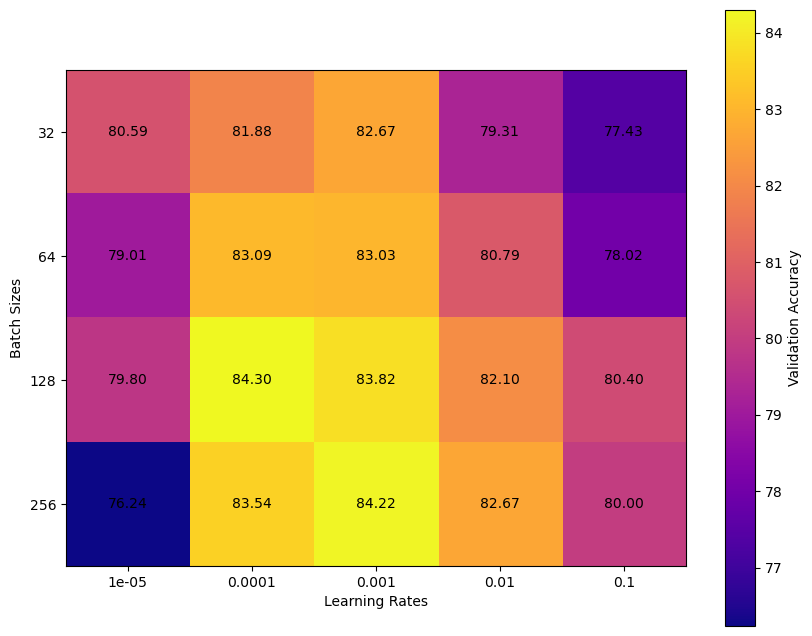

SGD heatmap


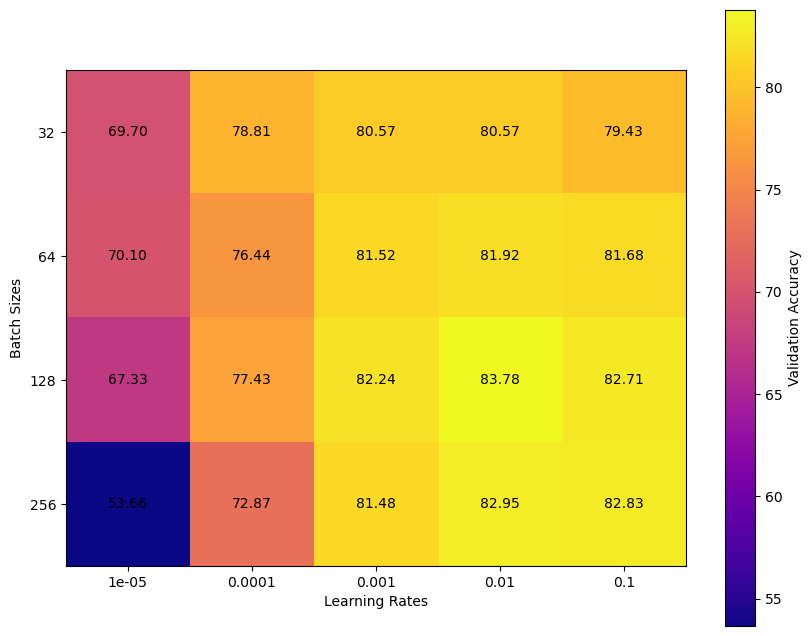

Rprop heatmap


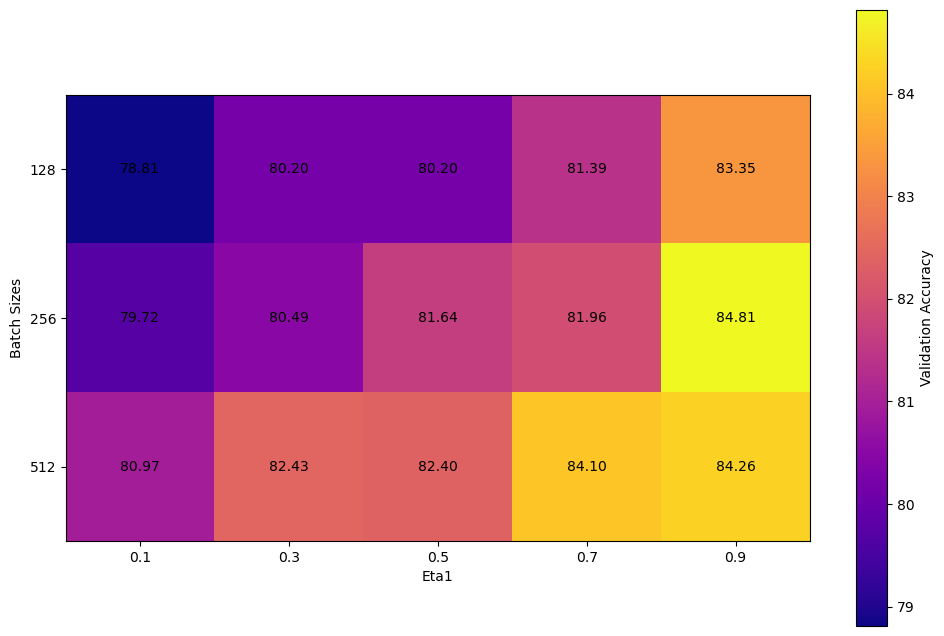

In [369]:
adam_lr_bss = extract_bests_twoway(all_adam_results_dicts, ['config', 'optimizer', 'Adam', 'lr'], ['config', 'batch_size'])
sgd_lr_bss = extract_bests_twoway(all_sgd_results_dicts, ['config', 'optimizer', 'SGD', 'lr'], ['config', 'batch_size'])
rprop_eta1_bss = extract_bests_twoway(all_rprop_results_dicts, ['config', 'optimizer', 'Rprop', 'eta1'], ['config', 'batch_size'])


print("Adam heatmap")
plot_heatmap(
    adam_lr_wds, 
    x_label='Learning Rates', 
    y_label='Batch Sizes', 
    title='', #'Accuracy Heatmap for Learning Rates and Weight Decays', 
    cmap='plasma',  # You can choose any colormap here
    figsize=(10, 8), 
    colorbar_label='Validation Accuracy',
    textcolor='black'
)

print("SGD heatmap")
plot_heatmap(
    sgd_lr_bss, 
    x_label='Learning Rates', 
    y_label='Batch Sizes', 
    title='', #'Accuracy Heatmap for Learning Rates and Batch Sizes', 
    cmap='plasma',  # You can choose any colormap here
    figsize=(10, 8), 
    colorbar_label='Validation Accuracy',
    textcolor='black'
)

print("Rprop heatmap")
plot_heatmap(
    rprop_eta1_bss, 
    x_label='Eta1', 
    y_label='Batch Sizes', 
    title='', #'Accuracy Heatmap for Eta1 and Batch Sizes', 
    cmap='plasma',  # You can choose any colormap here
    figsize=(12, 8), 
    colorbar_label='Validation Accuracy',
    textcolor='black'
)


# Statistical Tests & Analysis
The code below performs statistical analysis of collected data, such as ANOVA and other manual inspection techniques.

In [370]:
import pandas as pd
import numpy as np
from scipy import stats

def group_accs_by_hpar(results_dict, hpar_path):
    # collect the accuracies for each key
    groups = {}
    for result in results_dict:
        acc = result['avg_val_accuracy']
        k = get_nested_value(result, hpar_path)
        if k not in groups:
            groups[k] = []
        groups[k].append(acc)
    return groups
    
# Group the validation accuracies by learning rate
adam_lr_groups = group_accs_by_hpar(all_adam_results_dicts, ['config', 'batch_size'])

def perform_anova(groups):
    # Perform ANOVA on the groups
    f_stat, p_val = stats.f_oneway(*groups.values())
    return f_stat, p_val

def print_stats_for_hpar_bests(bests):
    accs = bests.values()
    # Print the 0th, 25th, 50th, 75th, and 100th percentiles
    print(f"Percentiles [0, 25, 50, 75, 100]: {np.percentile(list(accs), [0, 25, 50, 75, 100])}")
    print(f"IQR: {np.percentile(list(accs), 75) - np.percentile(list(accs), 25)}")
    print(f"Range: {np.max(list(accs)) - np.min(list(accs))}")
    print(f"Mean: {np.mean(list(accs))}")
    print(f"Standard Deviation: {np.std(list(accs))}")


In [371]:
# Perform ANOVA and print statistics for Adam
print("Adam Analysis:")
adam_lr_groups = group_accs_by_hpar(all_adam_results_dicts, ['config', 'optimizer', 'Adam', 'lr'])
adam_wd_groups = group_accs_by_hpar(all_adam_results_dicts, ['config', 'optimizer', 'Adam', 'weight_decay'])
adam_bs_groups = group_accs_by_hpar(all_adam_results_dicts, ['config', 'batch_size'])
adam_beta1_groups = group_accs_by_hpar(all_adam_results_dicts, ['config', 'optimizer', 'Adam', 'beta1'])
adam_beta2_groups = group_accs_by_hpar(all_adam_results_dicts, ['config', 'optimizer', 'Adam', 'beta2'])


f_stat_lr_adam, p_val_lr_adam = perform_anova(adam_lr_groups)
f_stat_wd_adam, p_val_wd_adam = perform_anova(adam_wd_groups)
f_stat_bs_adam, p_val_bs_adam = perform_anova(adam_bs_groups)
f_stat_beta1_adam, p_val_beta1_adam = perform_anova(adam_beta1_groups)
f_stat_beta2_adam, p_val_beta2_adam = perform_anova(adam_beta2_groups)

print(f"ANOVA results for Adam Learning Rates: F-statistic = {f_stat_lr_adam}, p-value = {p_val_lr_adam}")
print(f"ANOVA results for Adam Weight Decay: F-statistic = {f_stat_wd_adam}, p-value = {p_val_wd_adam}")
print(f"ANOVA results for Adam Batch Size: F-statistic = {f_stat_bs_adam}, p-value = {p_val_bs_adam}")
print(f"ANOVA results for Adam Beta1: F-statistic = {f_stat_beta1_adam}, p-value = {p_val_beta1_adam}")
print(f"ANOVA results for Adam Beta2: F-statistic = {f_stat_beta2_adam}, p-value = {p_val_beta2_adam}")

# Print statistics for the best Adam configurations
adam_lrs = extract_bests_oneway(all_adam_results_dicts, ['config', 'optimizer', 'Adam', 'lr'])
adam_wds = extract_bests_oneway(all_adam_results_dicts, ['config', 'optimizer', 'Adam', 'weight_decay'])
adam_bss = extract_bests_oneway(all_adam_results_dicts, ['config', 'batch_size'])
adam_beta1s = extract_bests_oneway(all_adam_results_dicts, ['config', 'optimizer', 'Adam', 'beta1'])
adam_beta2s = extract_bests_oneway(all_adam_results_dicts, ['config', 'optimizer', 'Adam', 'beta2'])

print()
print("Adam Learning Rates:")
print_stats_for_hpar_bests(adam_lrs)
print()

print("Adam Weight Decay:")
print_stats_for_hpar_bests(adam_wds)
print()

print("Adam Batch Size:")
print_stats_for_hpar_bests(adam_bss)
print()

print("Adam Beta1:")
print_stats_for_hpar_bests(adam_beta1s)
print()

# Perform ANOVA and print statistics for SGD
print("SGD Analysis:")
sgd_lr_groups = group_accs_by_hpar(all_sgd_results_dicts, ['config', 'optimizer', 'SGD', 'lr'])
sgd_wd_groups = group_accs_by_hpar(all_sgd_results_dicts, ['config', 'optimizer', 'SGD', 'weight_decay'])
sgd_bs_groups = group_accs_by_hpar(all_sgd_results_dicts, ['config', 'batch_size'])
sgd_momentum_groups = group_accs_by_hpar(all_sgd_results_dicts, ['config', 'optimizer', 'SGD', 'momentum'])

f_stat_lr_sgd, p_val_lr_sgd = perform_anova(sgd_lr_groups)
f_stat_wd_sgd, p_val_wd_sgd = perform_anova(sgd_wd_groups)
f_stat_bs_sgd, p_val_bs_sgd = perform_anova(sgd_bs_groups)
f_stat_momentum_sgd, p_val_momentum_sgd = perform_anova(sgd_momentum_groups)

print(f"ANOVA results for SGD Learning Rates: F-statistic = {f_stat_lr_sgd}, p-value = {p_val_lr_sgd}")
print(f"ANOVA results for SGD Weight Decay: F-statistic = {f_stat_wd_sgd}, p-value = {p_val_wd_sgd}")
print(f"ANOVA results for SGD Batch Size: F-statistic = {f_stat_bs_sgd}, p-value = {p_val_bs_sgd}")
print(f"ANOVA results for SGD Momentum: F-statistic = {f_stat_momentum_sgd}, p-value = {p_val_momentum_sgd}")

# Print statistics for the best SGD configurations
sgd_lrs = extract_bests_oneway(all_sgd_results_dicts, ['config', 'optimizer', 'SGD', 'lr'])
sgd_wds = extract_bests_oneway(all_sgd_results_dicts, ['config', 'optimizer', 'SGD', 'weight_decay'])
sgd_bss = extract_bests_oneway(all_sgd_results_dicts, ['config', 'batch_size'])
sgd_momentums = extract_bests_oneway(all_sgd_results_dicts, ['config', 'optimizer', 'SGD', 'momentum'])

print()
print("SGD Learning Rates:")
print_stats_for_hpar_bests(sgd_lrs)
print()

print("SGD Weight Decay:")
print_stats_for_hpar_bests(sgd_wds)
print()

print("SGD Batch Size:")
print_stats_for_hpar_bests(sgd_bss)
print()

print("SGD Momentum:")
print_stats_for_hpar_bests(sgd_momentums)
print()

# Perform ANOVA and print statistics for RProp
print("RProp Analysis:")
rprop_lr_groups = group_accs_by_hpar(all_rprop_results_dicts, ['config', 'optimizer', 'Rprop', 'lr'])
rprop_eta1_groups = group_accs_by_hpar(all_rprop_results_dicts, ['config', 'optimizer', 'Rprop', 'eta1'])
rprop_eta2_groups = group_accs_by_hpar(all_rprop_results_dicts, ['config', 'optimizer', 'Rprop', 'eta2'])
rprop_bs_groups = group_accs_by_hpar(all_rprop_results_dicts, ['config', 'batch_size'])
rprop_step_size_max_groups = group_accs_by_hpar(all_rprop_results_dicts, ['config', 'optimizer', 'Rprop', 'step_size_max'])

f_stat_lr_rprop, p_val_lr_rprop = perform_anova(rprop_lr_groups)
f_stat_eta1_rprop, p_val_eta1_rprop = perform_anova(rprop_eta1_groups)
f_stat_eta2_rprop, p_val_eta2_rprop = perform_anova(rprop_eta2_groups)
f_stat_bs_rprop, p_val_bs_rprop = perform_anova(rprop_bs_groups)
f_stat_step_size_max_rprop, p_val_step_size_max_rprop = perform_anova(rprop_step_size_max_groups)

print(f"ANOVA results for RProp Learning Rates: F-statistic = {f_stat_lr_rprop}, p-value = {p_val_lr_rprop}")
print(f"ANOVA results for RProp Eta1: F-statistic = {f_stat_eta1_rprop}, p-value = {p_val_eta1_rprop}")
print(f"ANOVA results for RProp Eta2: F-statistic = {f_stat_eta2_rprop}, p-value = {p_val_eta2_rprop}")
print(f"ANOVA results for RProp Batch Size: F-statistic = {f_stat_bs_rprop}, p-value = {p_val_bs_rprop}")
print(f"ANOVA results for RProp Step Size Max: F-statistic = {f_stat_step_size_max_rprop}, p-value = {p_val_step_size_max_rprop}")

# Print statistics for the best RProp configurations
rprop_lrs = extract_bests_oneway(all_rprop_results_dicts, ['config', 'optimizer', 'Rprop', 'lr'])
rprop_eta1s = extract_bests_oneway(all_rprop_results_dicts, ['config', 'optimizer', 'Rprop', 'eta1'])
rprop_eta2s = extract_bests_oneway(all_rprop_results_dicts, ['config', 'optimizer', 'Rprop', 'eta2'])
rprop_bss = extract_bests_oneway(all_rprop_results_dicts, ['config', 'batch_size'])
rprop_step_size_maxs = extract_bests_oneway(all_rprop_results_dicts, ['config', 'optimizer', 'Rprop', 'step_size_max'])

print()
print("RProp Learning Rates:")
print_stats_for_hpar_bests(rprop_lrs)
print()

print("RProp Eta1:")
print_stats_for_hpar_bests(rprop_eta1s)
print()

print("RProp Eta2:")
print_stats_for_hpar_bests(rprop_eta2s)
print()

print("RProp Batch Size:")
print_stats_for_hpar_bests(rprop_bss)
print()

print("RProp Step Size Max:")
print_stats_for_hpar_bests(rprop_step_size_maxs)
print()



Adam Analysis:
ANOVA results for Adam Learning Rates: F-statistic = 171.43097240325451, p-value = 5.534246248265802e-109
ANOVA results for Adam Weight Decay: F-statistic = 50.105671405571954, p-value = 4.43010632855022e-38
ANOVA results for Adam Batch Size: F-statistic = 4.348488824747691, p-value = 0.004726941482656831
ANOVA results for Adam Beta1: F-statistic = 3.2518856768956876, p-value = 0.03915789083041034
ANOVA results for Adam Beta2: F-statistic = 0.05888807121121264, p-value = 0.9428159356927801

Adam Learning Rates:
Percentiles [0, 25, 50, 75, 100]: [80.3960396  80.59405941 82.67334591 84.21829326 84.29757976]
IQR: 3.6242338519566175
Range: 3.9015401540154073
Mean: 82.43586358635864
Standard Deviation: 1.6883462327357943

Adam Weight Decay:
Percentiles [0, 25, 50, 75, 100]: [83.14851485 83.82186076 83.82311803 84.21829326 84.29757976]
IQR: 0.3964325003928906
Range: 1.1490649064906506
Mean: 83.86187333019015
Standard Deviation: 0.4071507226543307

Adam Batch Size:
Percentiles 

In [372]:
import numpy as np

def process_results(xxx_test_results):
    # Extract accuracy and loss data
    test_accuracies = np.array([result['test']['accuracy'] for result in xxx_test_results])
    test_losses = np.array([result['test']['loss'] for result in xxx_test_results])
    train_losses = np.array([result['train']['loss'] for result in xxx_test_results])

    # Calculate means and standard deviations
    acc_means = np.mean(test_accuracies, axis=0)
    acc_stds = np.std(test_accuracies, axis=0)

    final_accs = test_accuracies[:, -1].T
    final_test_losses = test_losses[:, -1].T
    
    test_loss_means = np.mean(test_losses, axis=0)
    test_loss_stds = np.std(test_losses, axis=0)

    train_loss_means = np.mean(train_losses, axis=0)
    train_loss_stds = np.std(train_losses, axis=0)

    # Transpose the arrays for plotting
    acc_means = acc_means.T
    acc_stds = acc_stds.T
    test_loss_means = test_loss_means.T
    test_loss_stds = test_loss_stds.T
    train_loss_means = train_loss_means.T
    train_loss_stds = train_loss_stds.T

    # Print final results
    print("Final Results")
    print(f"Mean Accuracy: {acc_means[-1]:.2f}%")
    print(f"Standard Deviation of accuracy: {acc_stds[-1]:.2f}")
    print(f"Mean Test Loss: {test_loss_means[-1]:.4f}")
    print(f"Standard Deviation of test loss: {test_loss_stds[-1]:.4f}")


    # Return the processed arrays
    return acc_means, acc_stds, test_loss_means, test_loss_stds, train_loss_means, train_loss_stds, final_accs, final_test_losses



In [373]:
print("Adam:")
adam_acc_means, adam_acc_stds, adam_test_loss_means, adam_test_loss_stds, adam_train_loss_means, adam_train_loss_stds, adam_final_accs, adam_final_test_losses = process_results(adam_test_results)
print()
print("Rprop:")
rprop_acc_means, rprop_acc_stds, rprop_test_loss_means, rprop_test_loss_stds, rprop_train_loss_means, rprop_train_loss_stds, rprop_final_accs, rprop_final_test_losses = process_results(rprop_test_results)
print()
print("SGD:")
sgd_acc_means, sgd_acc_stds, sgd_test_loss_means, sgd_test_loss_stds, sgd_train_loss_means, sgd_train_loss_stds, sgd_final_accs, sgd_final_test_losses = process_results(sgd_test_results)
print()
print("Hybrid all: ")
hybrid_all_acc_means, hybrid_all_acc_stds, hybrid_all_test_loss_means, hybrid_all_test_loss_stds, hybrid_all_train_loss_means, hybrid_all_train_loss_stds, hybrid_all_final_accs, hybrid_all_final_test_losses = process_results(hybrid_all_results)
print()
print("Hybrid Adam Rprop: ")
hybrid_adam_rprop_acc_means, hybrid_adam_rprop_acc_stds, hybrid_adam_rprop_test_loss_means, hybrid_adam_rprop_test_loss_stds, hybrid_adam_rprop_train_loss_means, hybrid_adam_rprop_train_loss_stds, hybrid_adam_rprop_final_accs, hybrid_adam_rprop_final_test_losses = process_results(hybrid_adam_rprop_results)
print()
print("Hybrid Adam SGD: ")
hybrid_adam_sgd_acc_means, hybrid_adam_sgd_acc_stds, hybrid_adam_sgd_test_loss_means, hybrid_adam_sgd_test_loss_stds, hybrid_adam_sgd_train_loss_means, hybrid_adam_sgd_train_loss_stds, hybrid_adam_sgd_final_accs, hybrid_adam_sgd_final_test_losses = process_results(hybrid_adam_sgd_results)
print()
print("Hybrid Rprop SGD: ")
hybrid_rprop_sgd_acc_means, hybrid_rprop_sgd_acc_stds, hybrid_rprop_sgd_test_loss_means, hybrid_rprop_sgd_test_loss_stds, hybrid_rprop_sgd_train_loss_means, hybrid_rprop_sgd_train_loss_stds, hybrid_rprop_sgd_final_accs, hybrid_rprop_sgd_final_test_losses = process_results(hybrid_rprop_sgd_results)
print()



Adam:
Final Results
Mean Accuracy: 87.97%
Standard Deviation of accuracy: 1.49
Mean Test Loss: 0.3842
Standard Deviation of test loss: 0.0562

Rprop:
Final Results
Mean Accuracy: 86.43%
Standard Deviation of accuracy: 1.02
Mean Test Loss: 0.4395
Standard Deviation of test loss: 0.0492

SGD:
Final Results
Mean Accuracy: 87.31%
Standard Deviation of accuracy: 1.04
Mean Test Loss: 0.3900
Standard Deviation of test loss: 0.0469

Hybrid all: 
Final Results
Mean Accuracy: 86.45%
Standard Deviation of accuracy: 1.33
Mean Test Loss: 0.4225
Standard Deviation of test loss: 0.0525

Hybrid Adam Rprop: 
Final Results
Mean Accuracy: 86.67%
Standard Deviation of accuracy: 1.21
Mean Test Loss: 0.4449
Standard Deviation of test loss: 0.0607

Hybrid Adam SGD: 
Final Results
Mean Accuracy: 86.95%
Standard Deviation of accuracy: 1.30
Mean Test Loss: 0.3854
Standard Deviation of test loss: 0.0779

Hybrid Rprop SGD: 
Final Results
Mean Accuracy: 85.05%
Standard Deviation of accuracy: 5.49
Mean Test Loss: 0

In [374]:
from scipy import stats
print("Adam vs Rprop:")
# Perform the Wilcoxon rank-sum test (Mann-Whitney U test)
stat, p_value = stats.mannwhitneyu(adam_final_accs, rprop_final_accs, alternative='two-sided')

# Print the results
print(f"Statistic: {stat}")
print(f"P-value: {p_value}")

print()
print("Adam vs SGD:")
# Perform the Wilcoxon rank-sum test (Mann-Whitney U test)
stat, p_value = stats.mannwhitneyu(adam_final_accs, sgd_final_accs, alternative='two-sided')

# Print the results
print(f"Statistic: {stat}")
print(f"P-value: {p_value}")

print()
print("Rprop vs SGD:")
# Perform the Wilcoxon rank-sum test (Mann-Whitney U test)
stat, p_value = stats.mannwhitneyu(rprop_final_accs, sgd_final_accs, alternative='two-sided')

# Print the results
print(f"Statistic: {stat}")
print(f"P-value: {p_value}")

print()
print("Hybrid all vs Adam:")
# Perform the Wilcoxon rank-sum test (Mann-Whitney U test)
stat, p_value = stats.mannwhitneyu(hybrid_all_final_accs, adam_final_accs, alternative='two-sided')

# Print the results
print(f"Statistic: {stat}")
print(f"P-value: {p_value}")

print()
print("Hybrid all vs Rprop:")
# Perform the Wilcoxon rank-sum test (Mann-Whitney U test)
stat, p_value = stats.mannwhitneyu(hybrid_all_final_accs, rprop_final_accs, alternative='two-sided')

# Print the results
print(f"Statistic: {stat}")
print(f"P-value: {p_value}")

print()
print("Hybrid all vs SGD:")
# Perform the Wilcoxon rank-sum test (Mann-Whitney U test)
stat, p_value = stats.mannwhitneyu(hybrid_all_final_accs, sgd_final_accs, alternative='two-sided')

# Print the results
print(f"Statistic: {stat}")
print(f"P-value: {p_value}")

Adam vs Rprop:
Statistic: 183.5
P-value: 0.0032547805992807167

Adam vs SGD:
Statistic: 140.0
P-value: 0.25532719731947395

Rprop vs SGD:
Statistic: 57.5
P-value: 0.022781537862564

Hybrid all vs Adam:
Statistic: 51.0
P-value: 0.01111010009070842

Hybrid all vs Rprop:
Statistic: 116.5
P-value: 0.8839701659387575

Hybrid all vs SGD:
Statistic: 74.5
P-value: 0.11753414520803097


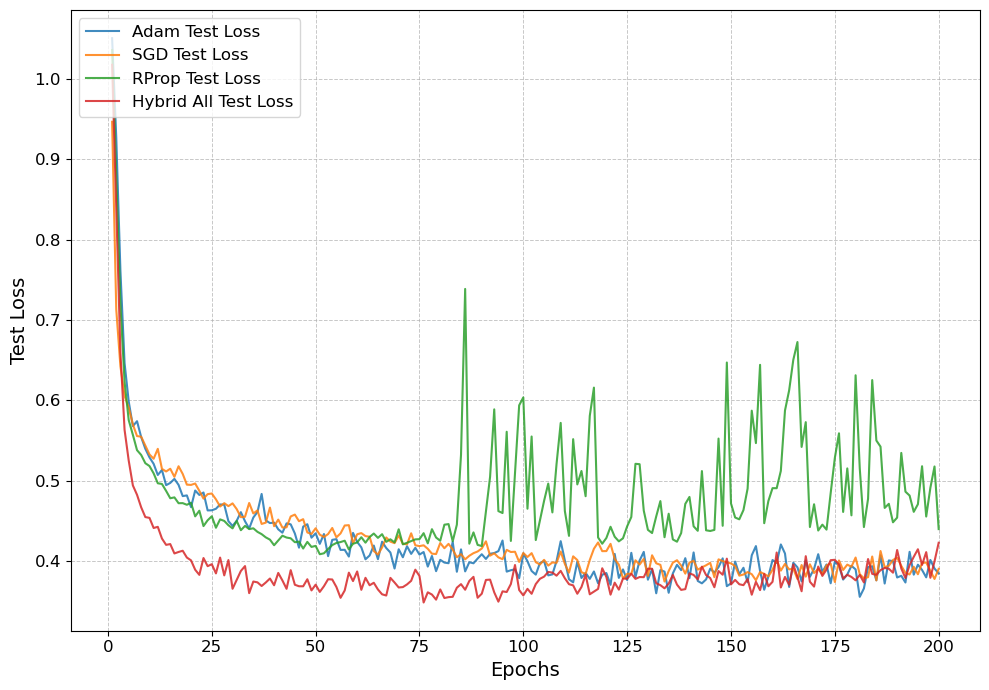

In [375]:
import matplotlib.pyplot as plt
import numpy as np


# X-axis values (e.g., epochs)
epochs = np.arange(1, len(adam_test_loss_means) + 1)

# Create a larger figure and axis for better visualization
plt.figure(figsize=(10, 7))

# Plot the lines separately
plt.plot(epochs, adam_test_loss_means, '-', label='Adam Test Loss', markersize=3, alpha=0.85)
plt.plot(epochs, sgd_test_loss_means, '-', label='SGD Test Loss', markersize=3, alpha=0.85)
plt.plot(epochs, rprop_test_loss_means, '-', label='RProp Test Loss', markersize=3, alpha=0.85)
plt.plot(epochs, hybrid_all_test_loss_means, '-', label='Hybrid All Test Loss', markersize=3, alpha=0.85)

# Add labels and title with larger font sizes
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Test Loss', fontsize=14)
# plt.title('Optimizer Accuracy with Standard Deviation Error Bars', fontsize=16)

# Add a grid with customized transparency
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Add a legend with a larger font size
plt.legend(loc='upper left', fontsize=12)

# Increase tick label size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

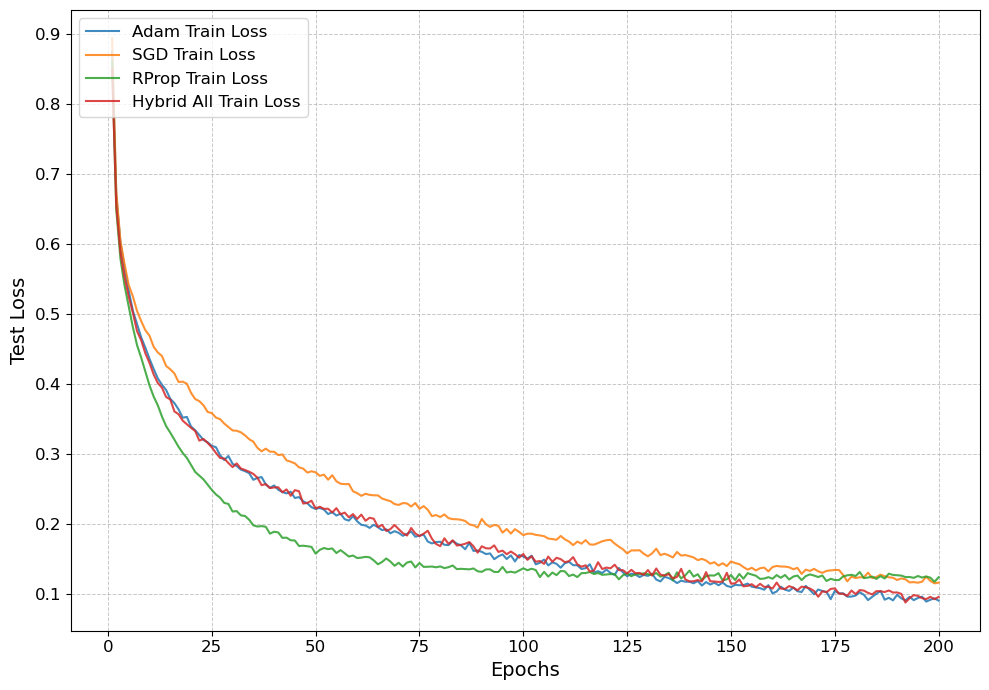

In [376]:
import matplotlib.pyplot as plt
import numpy as np


# X-axis values (e.g., epochs)
epochs = np.arange(1, len(adam_test_loss_means) + 1)

# Create a larger figure and axis for better visualization
plt.figure(figsize=(10, 7))

# Plot the lines separately
plt.plot(epochs, adam_train_loss_means, '-', label='Adam Train Loss', markersize=3, alpha=0.85)
plt.plot(epochs, sgd_train_loss_means, '-', label='SGD Train Loss', markersize=3, alpha=0.85)
plt.plot(epochs, rprop_train_loss_means, '-', label='RProp Train Loss', markersize=3, alpha=0.85)
plt.plot(epochs, hybrid_all_train_loss_means, '-', label='Hybrid All Train Loss', markersize=3, alpha=0.85)

# Add labels and title with larger font sizes
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Test Loss', fontsize=14)
# plt.title('Optimizer Accuracy with Standard Deviation Error Bars', fontsize=16)

# Add a grid with customized transparency
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Add a legend with a larger font size
plt.legend(loc='upper left', fontsize=12)

# Increase tick label size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

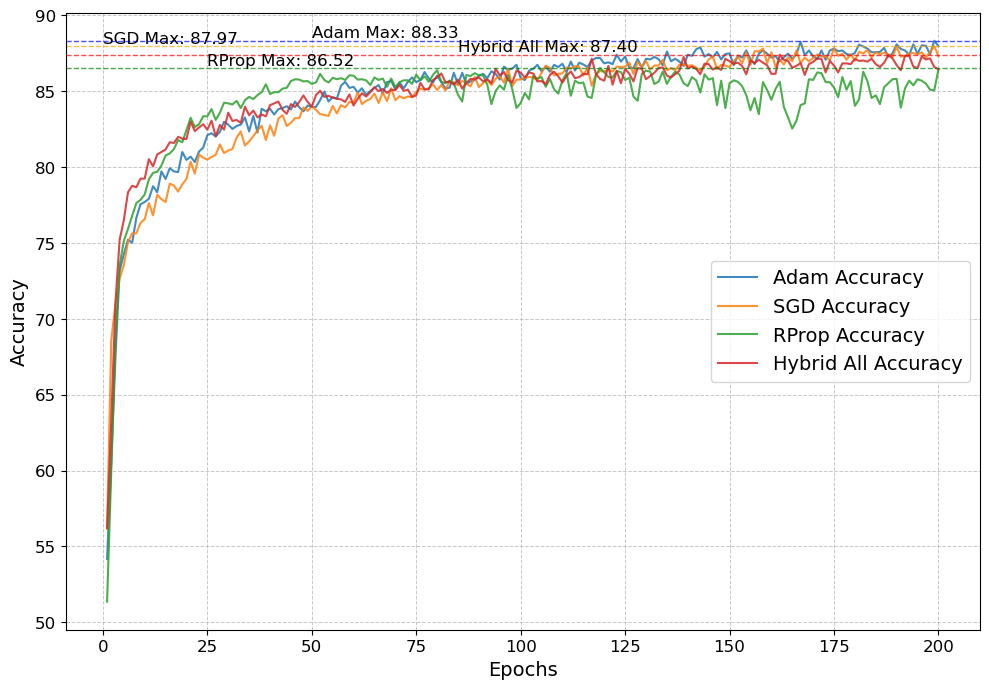

In [377]:
import matplotlib.pyplot as plt
import numpy as np

# X-axis values (e.g., epochs)
epochs = np.arange(1, len(adam_acc_means) + 1)

# Create a larger figure and axis for better visualization
plt.figure(figsize=(10, 7))

# Plot the lines separately
plt.plot(epochs, adam_acc_means, '-', label='Adam Accuracy', markersize=3, alpha=0.85)
plt.plot(epochs, sgd_acc_means, '-', label='SGD Accuracy', markersize=3, alpha=0.85)
plt.plot(epochs, rprop_acc_means, '-', label='RProp Accuracy', markersize=3, alpha=0.85)
plt.plot(epochs, hybrid_all_acc_means, '-', label='Hybrid All Accuracy', markersize=3, alpha=0.85)

# Get the max accuracy for each optimizer
adam_max_acc = np.max(adam_acc_means)
sgd_max_acc = np.max(sgd_acc_means)
rprop_max_acc = np.max(rprop_acc_means)
hybrid_all_max_acc = np.max(hybrid_all_acc_means)

# Plot horizontal lines for the max accuracy
plt.axhline(adam_max_acc, color='blue', linestyle='--', linewidth=1, alpha=0.7)
plt.axhline(sgd_max_acc, color='orange', linestyle='--', linewidth=1, alpha=0.7)
plt.axhline(rprop_max_acc, color='green', linestyle='--', linewidth=1, alpha=0.7)
plt.axhline(hybrid_all_max_acc, color='red', linestyle='--', linewidth=1, alpha=0.7)


# Annotate the max accuracy values
plt.text(len(epochs) - 150, adam_max_acc, f'Adam Max: {adam_max_acc:.2f}', color='black', fontsize=12, va='bottom', ha='left')
plt.text(len(epochs) - 200, sgd_max_acc, f'SGD Max: {sgd_max_acc:.2f}', color='black', fontsize=12, va='bottom', ha='left')
plt.text(len(epochs) - 175, rprop_max_acc, f'RProp Max: {rprop_max_acc:.2f}', color='black', fontsize=12, va='bottom', ha='left')
plt.text(len(epochs) - 115, hybrid_all_max_acc, f'Hybrid All Max: {hybrid_all_max_acc:.2f}', color='black', fontsize=12, va='bottom', ha='left')

# Add labels and title with larger font sizes
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
# plt.title('Optimizer Accuracy with Annotated Max Values', fontsize=16)

# Add a grid with customized transparency
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Add a legend with a larger font size
plt.legend(loc='center right', fontsize=14)

# Increase tick label size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
